In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# set a seaborn style of your taste
sns.set_style("whitegrid")

# Initial Data Exploration

In [2]:
# Importing DataSet
loans = pd.read_csv("loan.csv",parse_dates = True)
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [3]:
# Check for shape and Info
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [4]:
loans.shape

(39717, 111)

# Data Cleansing

In [5]:
# Checking for null values
loans.isnull().sum()

id                                    0
member_id                             0
loan_amnt                             0
funded_amnt                           0
funded_amnt_inv                       0
term                                  0
int_rate                              0
installment                           0
grade                                 0
sub_grade                             0
emp_title                          2459
emp_length                         1075
home_ownership                        0
annual_inc                            0
verification_status                   0
issue_d                               0
loan_status                           0
pymnt_plan                            0
url                                   0
desc                              12940
purpose                               0
title                                11
zip_code                              0
addr_state                            0
dti                                   0


In [6]:
# Remove Columns with all Null Values
loans.dropna(axis='columns', how='all', inplace=True)

In [7]:
#Droping the column with only 1 distict value
loans = loans[[col for col in list(loans) if len(loans[col].unique()) > 1]]

In [8]:
#Droping unwanted columns
remove = ['member_id','emp_title','url','desc','title', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'last_pymnt_d', 
       'next_pymnt_d','collections_12_mths_ex_med','chargeoff_within_12_mths', 'tax_liens']
loans.drop(remove, axis = 1, inplace = True)
loans.shape

(39717, 38)

In [9]:
#Checking duplicate values in loan dataframe
sum(loans.duplicated(subset = "id")) == 0
#True resembles no duplicacy

True

In [10]:
# Preparing the Term Column
loans['term'] = loans['term'].map(lambda x:x.rstrip('months'))
loans['term'] = pd.to_numeric(loans['term'])

In [11]:
# Preparing Interest Rate Column
loans ['int_rate_der'] = loans['int_rate'].map(lambda x:x.rstrip('%'))
loans['int_rate_der'] = pd.to_numeric(loans['int_rate_der'])

In [12]:
# Preparing Issue_Date Column
# Splitting Date to Month and Year

In [13]:
date_frame = loans['issue_d'].str.split("-",expand=True)
loans['issue_month'] = date_frame[0]
loans['issue_month'] = pd.to_datetime(loans['issue_month'],format = "%b")
loans['issue_year'] = date_frame[1]

In [14]:
# Derived columns
# Adding Loan Returns column
loans ['loan_returns'] = 100 *(((loans ['total_pymnt'] + loans ['recoveries'] + loans ['collection_recovery_fee'] + loans ['total_rec_late_fee']) - loans ['loan_amnt']) / loans ['loan_amnt']) 


# Univariate Analysis

## Loan Status

In [15]:
# For the analysis going forward we will be using dataset which excludes Current cases
loans_1 = loans.loc[loans['loan_status']!='Current',:]

In [16]:
# Checking for the proportion of Bad Loans (14.59%)
bad_loans_group = loans_1.groupby('loan_status')['loan_status'].count()
bad_loans_group

loan_status
Charged Off     5627
Fully Paid     32950
Name: loan_status, dtype: int64

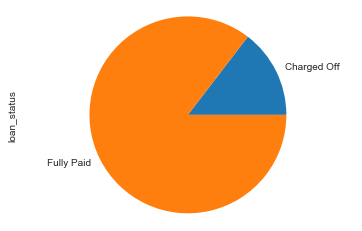

In [17]:
# Pie Plot shows the proportion
#Comparing Fully Paid(Good loan) and Charged Off(Bad loan)
bad_loans_group.plot(kind='pie')
plt.axis('equal')
plt.show()

## Annual Income

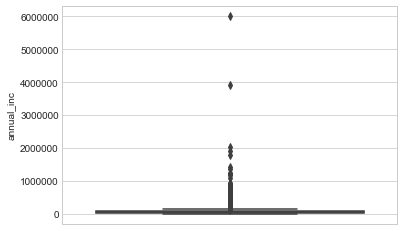

In [18]:
# Plotting Box Plot to see the distribution
sns.boxplot(y = loans_1['annual_inc'])
plt.show()

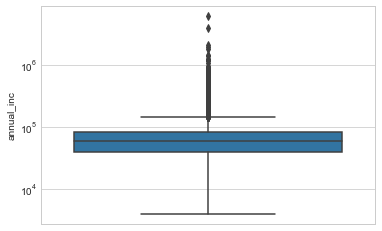

In [19]:
# The graph shows high population in the below 100000 zone and outliers above it. Lets plot Annual Income on log scale
sns.boxplot(y = loans_1['annual_inc'])
plt.yscale('log')
plt.show()

In [20]:
# Here we observed that there are there are a few outliers beyond 200000, which can skew our data. Let's find their proportion
income_outliers_perc = 100 * (len(loans_1.loc[loans_1['annual_inc']>200000]) / len(loans_1.loc[loans_1['annual_inc']]))
income_outliers_perc

1.4775643518158488

In [21]:
# Its a very miniscule data loss, and so for any subsequent Income related analysis we will be using the below data set
loans_income = loans_1.loc[loans_1['annual_inc'] < 200000,:]

## Loan Amount

In [22]:
# Loan Amount issued over time

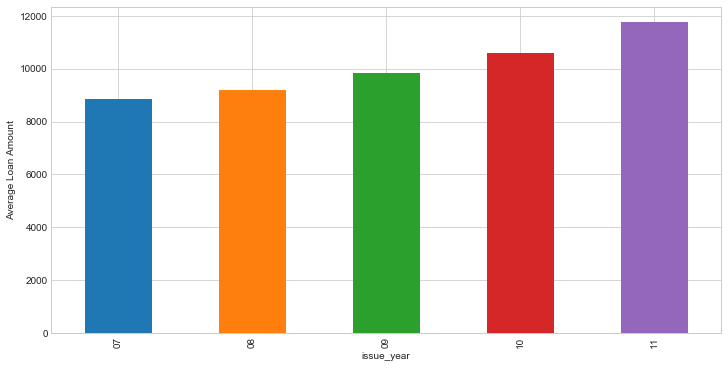

In [23]:
amnt_time = loans_1.groupby(['issue_year'])['loan_amnt'].mean()
amnt_time.plot(kind = 'bar', figsize = (12,6))
plt.ylabel('Average Loan Amount')
plt.show()

## Bad Loans %

In [24]:
bad_loans_time = loans_1.pivot_table(index = 'issue_year', columns = 'loan_status',values = 'id',aggfunc = 'count')
bad_loans_time['Bad_Loans_perc'] = 100 *(bad_loans_time['Charged Off'] / (bad_loans_time['Charged Off'] + bad_loans_time['Fully Paid']))
bad_loans_time.reset_index(inplace = True)
bad_loans_time

loan_status,issue_year,Charged Off,Fully Paid,Bad_Loans_perc
0,07,45,206,17.928287
1,08,247,1315,15.813060
2,09,594,4122,12.595420
3,10,1485,10047,12.877211
4,11,3256,17260,15.870540


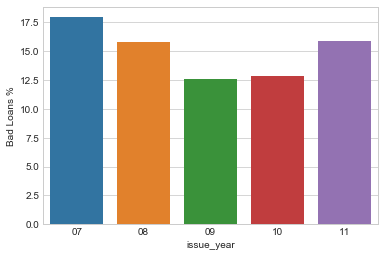

In [25]:
sns.barplot(x = 'issue_year', y = 'Bad_Loans_perc',data = bad_loans_time)
plt.ylabel('Bad Loans %')
plt.show()

## Delinquency in last 2 years

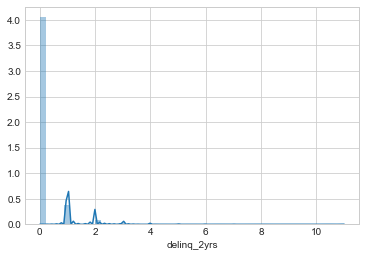

In [26]:
# Distribution plot for Delinquency in last 2 years
sns.distplot(loans_1['delinq_2yrs'])
plt.show()

In [27]:
# Since most of the values are zero, this variable will not be used

## Open Lines of Credit

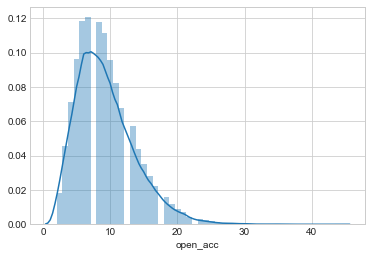

In [28]:
# Distribution plot for Delinquency in last 2 years
sns.distplot(loans_1['open_acc'])
plt.show()

In [29]:
# The data is a normal distribution and offers a good spread

# Bi-Variate Analysis

## Grade

In [30]:
# Grade vs Bad Loans %

In [31]:
grade_analysis1 = loans_1.pivot_table(index = 'grade', columns = 'loan_status',values = 'id',aggfunc = 'count')
grade_analysis1['Bad_Loans_perc'] = 100 *(grade_analysis1['Charged Off'] / (grade_analysis1['Charged Off'] + grade_analysis1['Fully Paid']))
grade_analysis1.reset_index(inplace = True)
grade_analysis1

loan_status,grade,Charged Off,Fully Paid,Bad_Loans_perc
0,A,602,9443,5.993031
1,B,1425,10250,12.205567
2,C,1347,6487,17.194281
3,D,1118,3967,21.986234
4,E,715,1948,26.849418
5,F,319,657,32.684426
6,G,101,198,33.779264


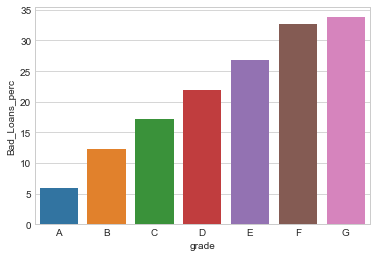

In [32]:
# Plotting a Bar Chart to visualize
sns.barplot(x = 'grade', y = 'Bad_Loans_perc',data = grade_analysis1)
plt.show()

In [33]:
# Grade vs Returns
grade_analysis2 = loans_1.groupby('grade')['loan_returns'].mean()
grade_analysis2

grade
A     5.396501
B     8.435210
C     9.901457
D    11.342839
E    11.803884
F    12.879800
G    13.077309
Name: loan_returns, dtype: float64

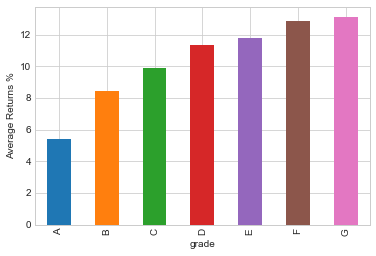

In [34]:
# Plotting a bar graph
grade_analysis2.plot(kind = 'bar')
plt.ylabel('Average Returns %')
plt.show()

## Employment Length

In [35]:
# vs Bad Loans%

In [36]:
empl_analysis1 = loans_1.pivot_table(index = 'emp_length', columns = 'loan_status',values = 'id',aggfunc = 'count')
empl_analysis1['Bad_Loans_perc'] = 100 *(empl_analysis1['Charged Off'] / (empl_analysis1['Charged Off'] + empl_analysis1['Fully Paid']))
empl_analysis1.reset_index(inplace = True)
empl_analysis1

loan_status,emp_length,Charged Off,Fully Paid,Bad_Loans_perc
0,1 year,456,2713,14.389397
1,10+ years,1331,7157,15.680961
2,2 years,567,3724,13.213703
3,3 years,555,3457,13.833500
4,4 years,462,2880,13.824057
5,5 years,458,2736,14.339386
6,6 years,307,1861,14.160517
7,7 years,263,1448,15.371128
8,8 years,203,1232,14.146341
9,9 years,158,1068,12.887439


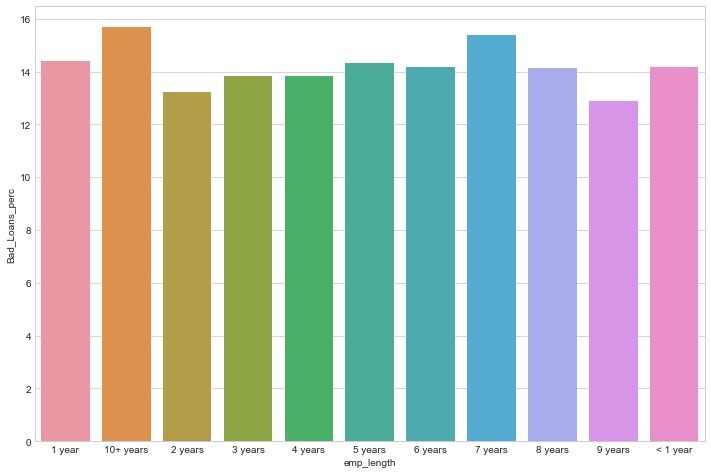

In [37]:
# Plotting a Bar Chart to visualize
plt.figure(figsize = (12,8))
sns.barplot(x = 'emp_length', y = 'Bad_Loans_perc',data = empl_analysis1)
plt.show()

In [38]:
# Employment Length vs Returns

In [39]:
empl_analysis2 = loans_1.groupby('emp_length')['loan_returns'].mean()
empl_analysis2

emp_length
1 year        8.211160
10+ years     8.436133
2 years       9.400210
3 years       9.209926
4 years       8.995114
5 years       9.368731
6 years       8.915360
7 years       8.656484
8 years       8.895777
9 years      10.054983
< 1 year      8.616901
Name: loan_returns, dtype: float64

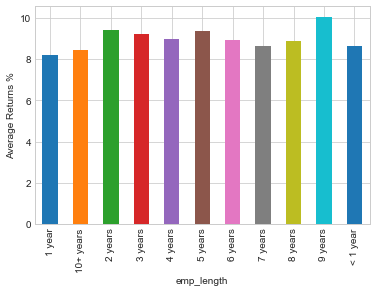

In [40]:
#Plotting bar
empl_analysis2.plot(kind = 'bar')
plt.ylabel('Average Returns %')
plt.show()

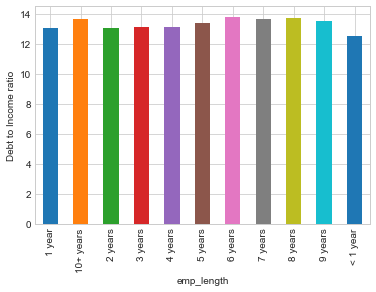

In [41]:
# Further exploration of employment length to see if Debt to Income ratio (Risk Aversiveness) has any linkage with Employment Length
empl_analysis3 = loans_1.groupby('emp_length')['dti'].mean()
empl_analysis3.plot(kind = 'bar')
plt.ylabel('Debt to Income ratio')
plt.show()

## Loan Amount

In [42]:
# Loan amount vs Loan Status
amnt_analysis1 = loans_1.groupby('loan_status')['loan_amnt'].mean()
amnt_analysis1

loan_status
Charged Off    12104.385108
Fully Paid     10866.455994
Name: loan_amnt, dtype: float64

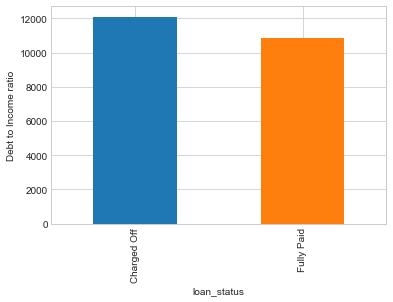

In [43]:
amnt_analysis1.plot(kind = 'bar')
plt.ylabel('Debt to Income ratio')
plt.show()

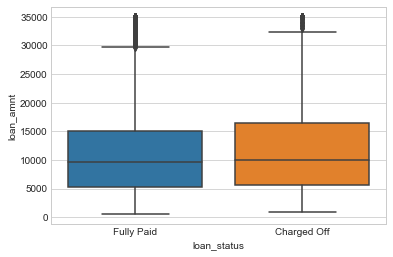

In [44]:
sns.boxplot(x = 'loan_status', y ='loan_amnt', data = loans_1 )
plt.show()

In [45]:
# Loan amount vs Returns

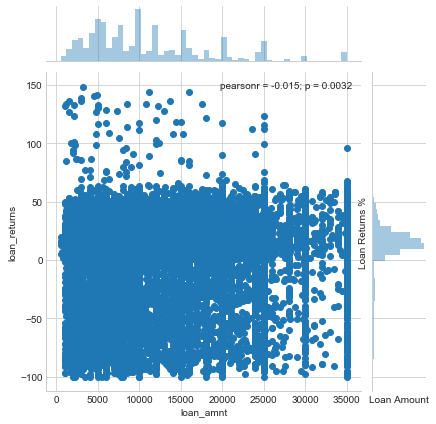

In [46]:
sns.jointplot('loan_amnt','loan_returns',loans_1)
plt.xlabel('Loan Amount')
plt.ylabel('Loan Returns %')
plt.show()

## Home Ownership

In [47]:
# Home Ownership bad loans %
home_analysis1 = loans_1.pivot_table(index = 'home_ownership', columns = 'loan_status',values = 'id',aggfunc = 'count')
home_analysis1['Bad_Loans_perc'] = 100 *(home_analysis1['Charged Off'] / (home_analysis1['Charged Off'] + home_analysis1['Fully Paid']))
home_analysis1.reset_index(inplace = True)
home_analysis1.sort_values(by = 'Bad_Loans_perc')
home_analysis1

loan_status,home_ownership,Charged Off,Fully Paid,Bad_Loans_perc
0,MORTGAGE,2327.0,14694.0,13.671347
1,NONE,NaN,3.0,NaN
2,OTHER,18.0,80.0,18.367347
3,OWN,443.0,2532.0,14.890756
4,RENT,2839.0,15641.0,15.362554


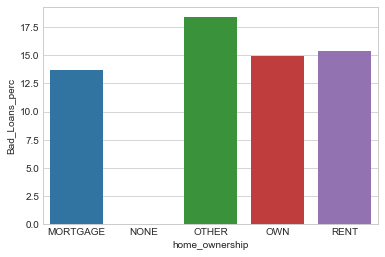

In [48]:
# Plotting a Bar Chart to visualize
sns.barplot(x = 'home_ownership', y = 'Bad_Loans_perc',data = home_analysis1)
plt.show()

In [49]:
# Home Ownership vs returns
home_analysis2 = loans_1.groupby('home_ownership')['loan_returns'].mean()
home_analysis2

home_ownership
MORTGAGE     8.767791
NONE        13.976844
OTHER        3.261936
OWN          7.997971
RENT         8.791001
Name: loan_returns, dtype: float64

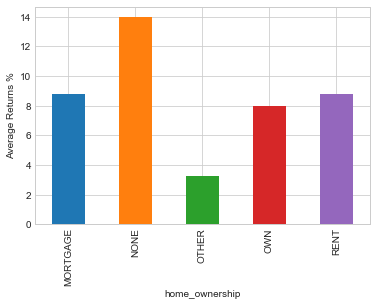

In [50]:
home_analysis2.plot(kind = 'bar')
plt.ylabel('Average Returns %')
plt.show()

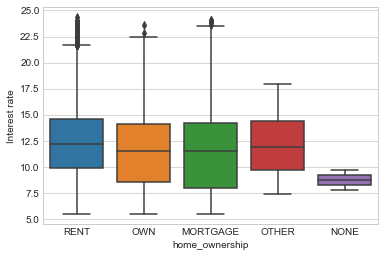

In [51]:
# Since Rent has high proportion, let's check for if people not owning have higher interest rate affecting higher defaults

sns.boxplot(x = 'home_ownership', y = 'int_rate_der', data = loans_1)
plt.ylabel('Interest rate')
plt.show()

## Interest Rate

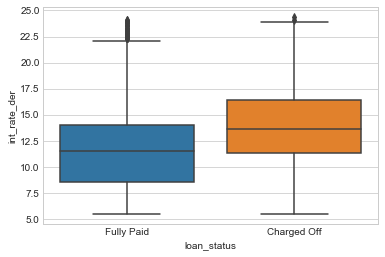

In [52]:
# To check if interest is indeed a factor
sns.boxplot(x = 'loan_status', y = 'int_rate_der', data = loans_1)
plt.show()

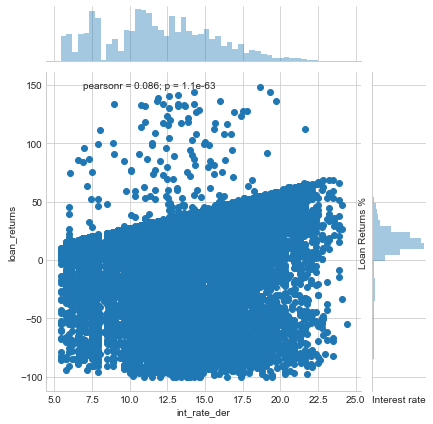

In [53]:
# Interest rate vs Loan Returns %
sns.jointplot('int_rate_der','loan_returns',loans_1)
plt.xlabel('Interest rate')
plt.ylabel('Loan Returns %')
plt.show()

In [54]:
# Splitting data set in two high interest (>14%) and low interest rate (<= 14%)
loans_high_intr = loans_1.loc[loans_1['int_rate_der'] > 14,:]
loans_low_intr = loans_1.loc[(loans_1['int_rate_der'] < 14) | (loans_1['int_rate_der'] == 14),:]

In [55]:
# Calculating Net Gain/Loss for High Interest Loans
loans_high_intr['interest_gained'] = (loans_high_intr['installment']*loans_high_intr['term'])-loans_high_intr['loan_amnt'] 
loans_high_intr['amount_lost'] = (loans_high_intr['installment']*loans_high_intr['term'])-(loans_high_intr['total_pymnt'] + loans_high_intr['recoveries'] + loans_high_intr['collection_recovery_fee'])
net_gain_loss_high_intr = loans_high_intr['interest_gained'].sum()-loans_high_intr['amount_lost'].sum()
net_gain_loss_high_intr

16140570.184620023

In [56]:
# Calculating Net Gain/Loss for Low Interest Loans
loans_low_intr['interest_gained'] = (loans_low_intr['installment']*loans_low_intr['term'])-loans_low_intr['loan_amnt'] 
loans_low_intr['amount_lost'] = (loans_low_intr['installment']*loans_low_intr['term'])-(loans_low_intr['total_pymnt'] + loans_low_intr['recoveries'] + loans_low_intr['collection_recovery_fee'])
net_gain_loss_low_intr = loans_low_intr['interest_gained'].sum()-loans_low_intr['amount_lost'].sum()
net_gain_loss_low_intr

19765096.3802984

## Purpose

In [57]:
# Creating DataFrame with just the written off loans
loans_charged_off = loans_1.loc[loans_1['loan_status'] == 'Charged Off',:]

In [58]:
# Purpose vs Bad Loans %
purpose_analysis_count_entire = loans_1.groupby('purpose')['id'].count()
purpose_analysis_count_entire = pd. DataFrame(purpose_analysis_count_entire)
purpose_analysis_count_entire = purpose_analysis_count_entire.reset_index()
purpose_analysis_count_charged_off = loans_charged_off.groupby('purpose')['id'].count()
purpose_analysis_count_charged_off = pd. DataFrame(purpose_analysis_count_charged_off)
purpose_analysis_count_charged_off = purpose_analysis_count_charged_off.reset_index()
purpose_count_table = pd.merge(purpose_analysis_count_charged_off, purpose_analysis_count_entire, how='inner', on='purpose')
purpose_count_table['Bad_Loans_perc'] = 100 *(purpose_count_table['id_x'] / (purpose_count_table['id_x'] + 
                                                                                    purpose_count_table['id_y']))
purpose_count_table. sort_values(by = 'Bad_Loans_perc', ascending = False,inplace = True)
purpose_count_table

,purpose,id_x,id_y,Bad_Loans_perc
11,small_business,475,1754,21.310004
10,renewable_energy,19,102,15.702479
3,educational,56,325,14.698163
9,other,633,3865,14.072921
5,house,59,367,13.849765
8,moving,92,576,13.772455
7,medical,106,681,13.468869
2,debt_consolidation,2767,18055,13.288829
12,vacation,53,375,12.383178
4,home_improvement,347,2875,10.769708


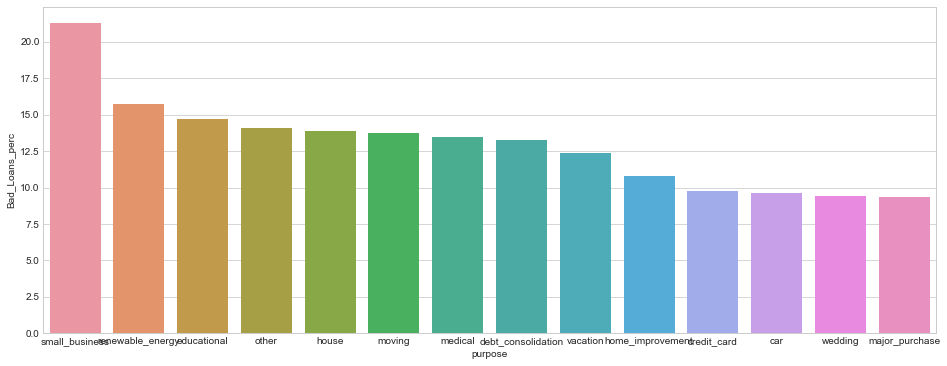

In [59]:
# PLotting bar plot
plt.figure(figsize= (16,6))
sns.barplot( x = 'purpose', y = 'Bad_Loans_perc', data = purpose_count_table)
plt.show()

In [60]:
# Now let's see in terms of amount which purpose has maximum amount of loans written off
purpose_analysis_amnt = loans_charged_off.groupby('purpose')['loan_amnt'].mean()
purpose_analysis_amnt

purpose
car                    7264.218750
credit_card           13014.944649
debt_consolidation    13517.925551
educational            7858.928571
home_improvement      11913.688761
house                 12640.254237
major_purchase         9135.022523
medical                8568.396226
moving                 5936.141304
other                  8284.873618
renewable_energy       8421.052632
small_business        14604.894737
vacation               5875.943396
wedding               10786.979167
Name: loan_amnt, dtype: float64

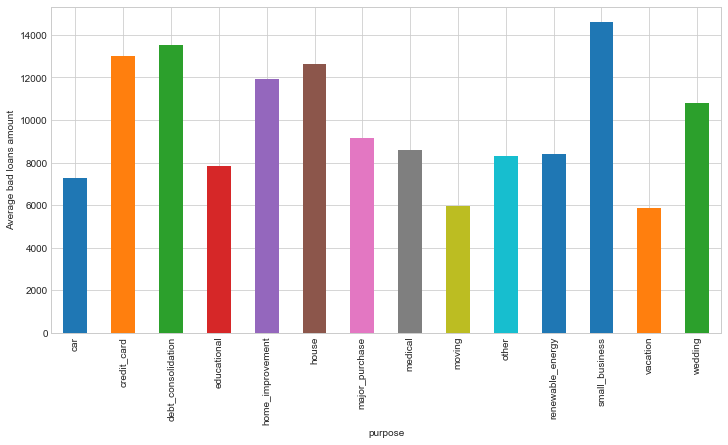

In [61]:
purpose_analysis_amnt.plot(kind='bar',figsize = (12,6))
plt.ylabel('Average bad loans amount')
plt.show()

## Debt to Income

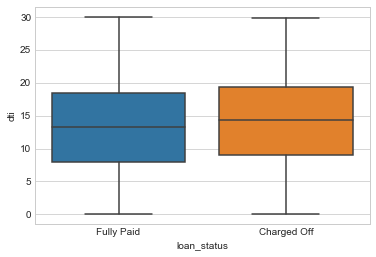

In [62]:
# DTI vs loan status
sns.boxplot(x = 'loan_status', y = 'dti', data = loans_1)
plt.show()

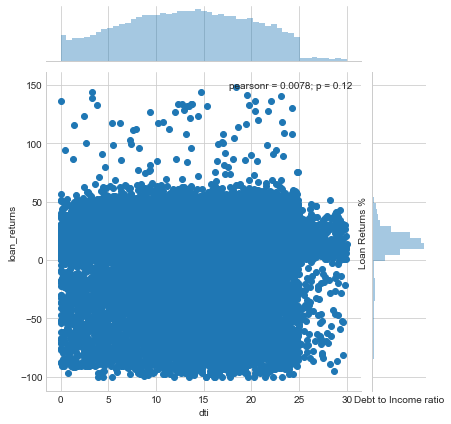

In [63]:
# DTI vs Loan Returns %
sns.jointplot('dti','loan_returns',loans_1)
plt.xlabel('Debt to Income ratio')
plt.ylabel('Loan Returns %')
plt.show()

## Open Lines of Credit

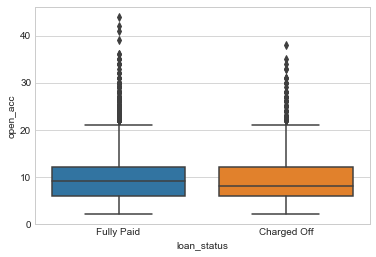

In [64]:
# Open lines of credit vs loan status
sns.boxplot(x = 'loan_status', y = 'open_acc', data = loans_1)
plt.show()

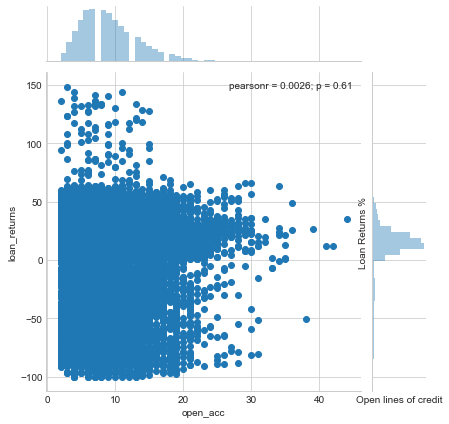

In [65]:
# Open Lines of Credit vs Loan Returns %
sns.jointplot('open_acc','loan_returns',loans_1)
plt.xlabel('Open lines of credit')
plt.ylabel('Loan Returns %')
plt.show()